#              Linear regression of Air quality data in Buenos Aires

data set taken from
https://data.buenosaires.gob.ar/dataset/calidad-aire/resource/3b99eb11-7d23-442d-8cf1-08abd16ad0b2

### Table of contents

0. <b> Introduction: Dataset </b>
   <br> 0.1. Importing libraries 
   <br> 0.2. Variables Selection 
1. <b> Preprocessing data </b>
   <br> 1.1. Resampling
2. <b> Model 1: Normal distribution </b>
   <br> 2.1. Setting up the model 
   <br> 2.2. Prior predictive
   <br> 2.3. Sampler performance analysis 
   <br> 2.4. Posterior and Posterior-predictive
3. <b> Model 2: Student T distribution </b>
   <br> 3.1. Setting up the model 
   <br> 3.2. Prior predictive
   <br> 3.3. Sampler performance analysis 
   <br> 3.4. Posterior and Posterior-predictive
4. <b> Model 3: Outlier classifier model </b>
   <br> 4.1. Setting up the model 
   <br> 4.2. Prior predictive
   <br> 4.3. Sampler performance analysis 
   <br> 4.4. Posterior and Posterior-predictive
5. <b> Model comparison </b>
   <br> 5.1. Comparison of posterior distribution
   <br> 5.2. Posterior regression means
   <br> 5.3. Deviance analysis: PSIS
    

## Introduction 

#### 0.1. Importing libraries and data

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv('calidad-de-aire-2019.csv')
data.head()

,fecha,hora,co_centenario,no2_centenario,pm10_centenario,co_cordoba,no2_cordoba,pm10_cordoba,co_la_boca,no2_la_boca,pm10_la_boca
0,2019-01-01,1,0.46,7,19,0.36,11,s/d,0.48,10,23
1,2019-01-01,2,0.47,9,19,0.41,13,s/d,0.46,11,23
2,2019-01-01,3,0.48,11,19,0.46,12,s/d,0.46,12,23
3,2019-01-01,4,0.48,16,19,0.50,10,s/d,0.46,11,24
4,2019-01-01,5,0.46,10,19,0.54,10,s/d,0.45,9,24


#### 0.2. Variable selection

The dataset is about the pollution levels in Argentina for the year of 2019. I chose this dataset because it seemed recent and relevant. The dataset has measurements of Carbonmonoxide (CO) and Nitrogendioxide (NO2) levels in different parts of the country. After looking at the data, I chose 'CO_centranario' and 'NO2_centenario' (measurement of the two compounds in Centenario, a city in the Southwestern part of Argentina) as my variables. 
I chose CO levels as my predictor variable and NO2 levels as my outcome variable. These two gases are both considered toxic pollutants resulting from burning diesel and I wanted to explore the probability of observing the other if one of them is present in the air.

In [3]:
print(f'There are {data.shape[0]} data points')

There are 2868 data points


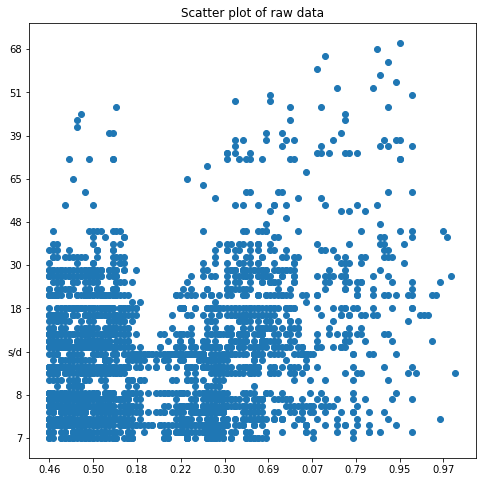

In [4]:
plt.figure(figsize = (8, 8))
plt.scatter(data['co_centenario'], data['no2_centenario'])
x = np.linspace(0, 100, 10)
y = np.linspace(0, 60, 10)
plt.xticks(x)
plt.yticks(y)
plt.title('Scatter plot of raw data')
plt.show()

### 1. Preprocessing data

The data looks like a mess right now. It currently has 2868 rows and there are several recordings for the same day, which creates disorganised stacks of data. I cleaned this data to have a better understanding of the data   

In [5]:
data.dtypes #checking the data types in the dataframe

fecha              object
hora                int64
co_centenario      object
no2_centenario     object
pm10_centenario    object
co_cordoba         object
no2_cordoba        object
pm10_cordoba       object
co_la_boca         object
no2_la_boca        object
pm10_la_boca       object
dtype: object

#### 1.1. Resampling

Resampling groups the data by day and finds the average CO and NO2 levels for each day. This helps us understand the general long term trend in the data without letting hour-to-hour differences disrupt our analysis

In [6]:
#converting the relevant columns into a data type that can be processed easily
data['fecha'] = pd.to_datetime(data['fecha'])
data['co_centenario'] = pd.to_numeric(data['co_centenario'], errors='coerce')
data['no2_centenario'] = pd.to_numeric(data['no2_centenario'], errors='coerce')
data.dtypes

fecha              datetime64[ns]
hora                        int64
co_centenario             float64
no2_centenario            float64
pm10_centenario            object
co_cordoba                 object
no2_cordoba                object
pm10_cordoba               object
co_la_boca                 object
no2_la_boca                object
pm10_la_boca               object
dtype: object

In [7]:
data = data.dropna() #dropping NaN values

In [8]:
#I don't want data for different hours of a day so I'm resampling by taking the average of a day
air = data.resample('D', on='fecha').agg({'co_centenario':np.mean, 'no2_centenario':np.mean})
print(f'After resampling, we have {air.shape[0]} data points')

After resampling, we have 120 data points


In [9]:
air = air.dropna() #doing this once more to drop all NaN values
print(f'Our final dataset has {air.shape[0]} data points')

Our final dataset has 116 data points


In [10]:
air.head()

,co_centenario,no2_centenario
fecha,,
2019-01-01,0.425000,10.583333
2019-01-02,0.477273,14.045455
2019-01-03,0.177083,13.583333
2019-01-04,0.271250,18.333333
2019-01-05,0.273750,12.750000


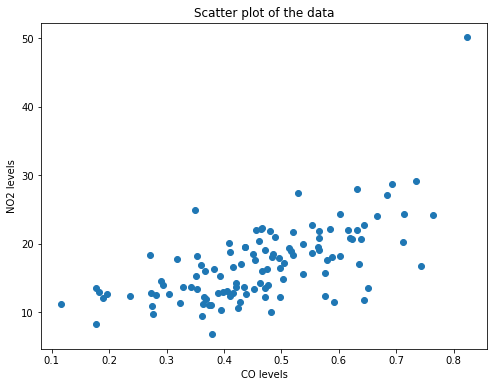

In [11]:
#plotting that data
fig, ax = plt.subplots(1,1, figsize=(8, 6)) 
x = air['co_centenario']
y = air['no2_centenario']
ax.scatter(x, y)
ax.set_xlabel('CO levels')
ax.set_ylabel('NO2 levels')
ax.set_title('Scatter plot of the data')
plt.show()

The data seems to have a linear relationship. There is one outlier value that is away from the general trend. I would expect the regression lines to be impacted by the outlier value 

### 2. Model 1: Normal likelihood

For the first model I have a normal likelihood. The mean of the normal distribution comes from a linear model, with parameters $\alpha$, the y-intercept, and $\beta$, the slope. Hence we have prior distributions over $\alpha$, $\beta$, for the $\mu$, and $\sigma$, which directly goes into the Normal distribution.

#### 2.1. Setting up the model

Likelihood:

$$y_i \sim \text{Normal}(\mu_i, \sigma^2)$$

$$\mu_i = \alpha + \beta x_i$$

Priors:

$$\alpha \sim \text{Uniform}(0,100)$$

$$\beta \sim \text{Normal}(0,5)$$

$$\sigma \sim \text{Uniform}(0, 100)$$



The $\alpha$ parameter follows a uniform distribution. NO2 levels are usually around 50 ppb, so a range 0 - 100 seems plausible. For the $\beta$ paramter, I'm using a Normal prior to account for negative and positive slopes and $\sigma$ prior is wide uniform with a range 0 - 100

I set up the priors for $\sigma$, $\alpha$ and $\beta$ to be wide so we do not exclude any possibilities. I do not have much knowledge about the concentration levels of environmental pollutants and hence cannot inform my priors with my knowledge.

In [12]:
data_x = np.array(air['co_centenario'])
data_y = np.array(air['no2_centenario'])

In [18]:
#setting up the model
with pm.Model() as normal_model:
    # Prior
    a = pm.Uniform('a', lower=0, upper=100)
    b = pm.Normal('b', mu=0, sigma=50)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    # Data
    x = pm.MutableData('x', data_x)
    y = pm.MutableData('y', data_y)
    # Regression mean
    mu = pm.Deterministic('mu', a + b*x)
    # Likelihood
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)


#### 2.2. Prior predictive

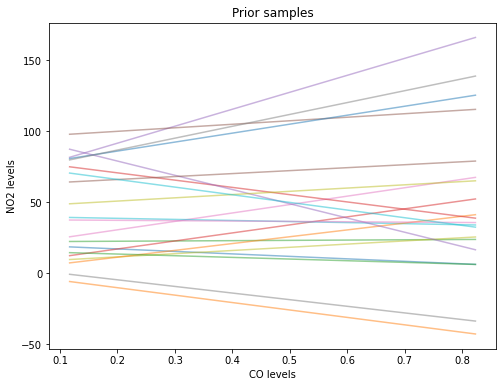

In [19]:
#code adapted from CS146 session 7: linear regression, notebook 'Linear regression' 

with normal_model:
    prior_inference_normal = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('CO levels')
plt.ylabel('NO2 levels')
plot_x = np.array([data_x.min(), data_x.max()])
plot_y = (
    prior_inference_normal.prior.a.values +
    plot_x.reshape(-1, 1) * prior_inference_normal.prior.b.values)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

The prior predictive encompases all possible regression lines, even the ones that go into the negatives because the model does not know the state of the world right now. This prior seems wide, but that is good because we can always narrow it down when the model learns from the data, but if we restrict the model from the start, it might miss important trends in the data. 

In [20]:
with normal_model:
    inference_normal = pm.sample(500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 528 seconds.


#### 2.3. Sampler performance analysis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.926,1.398,2.429,7.655,0.050,0.035,796.0,772.0,1.01
b,26.050,2.875,20.482,31.265,0.104,0.074,761.0,459.0,1.01
sigma,4.399,0.305,3.870,4.968,0.010,0.007,926.0,906.0,1.01


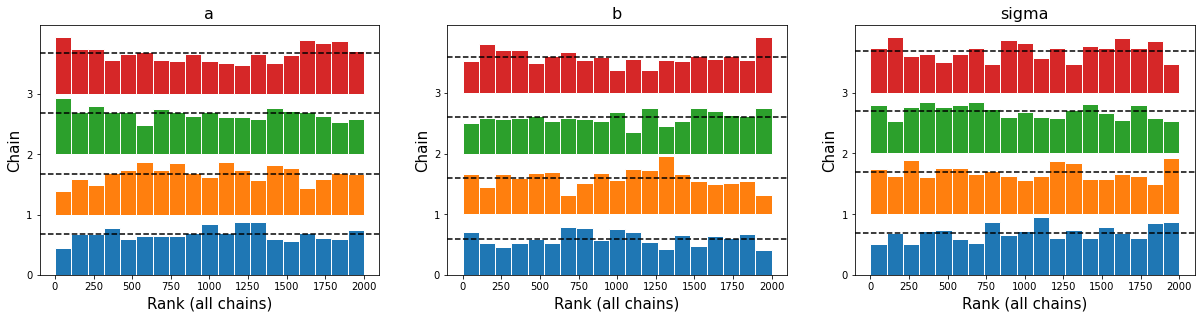

In [21]:
#code adapted from CS146 session 8:Robust linear regression, codebook 'Outlier classifier model: Posteriors'

az.plot_rank(inference_normal, var_names=['a', 'b', 'sigma'])
az.summary(inference_normal, var_names=['a', 'b', 'sigma'])

According to the inference summary table, the $\hat{r}$ values are well within range at 1. The ESS values are also high enough to represent at least 10% of the samples.
The rank plots show that the sampler is using 4 chains and there are some discrepencies that need to be highlighted. The plots seem vaguely uniform. The 4th chain (red) is unevenly distributed at times and the 3rd chain (green) for b and sigma have a few high density points. 
I ran the inference with 500 and 1000 samples to see if more samples would improve the results. The $\hat{r}$ value came down to 1 (from 1.01) after running a larger sample and the rank plots became more unifrom as well. Hence, I concluded that the sampler is running fine, even with a few discrepencies seen in the rank plots.  

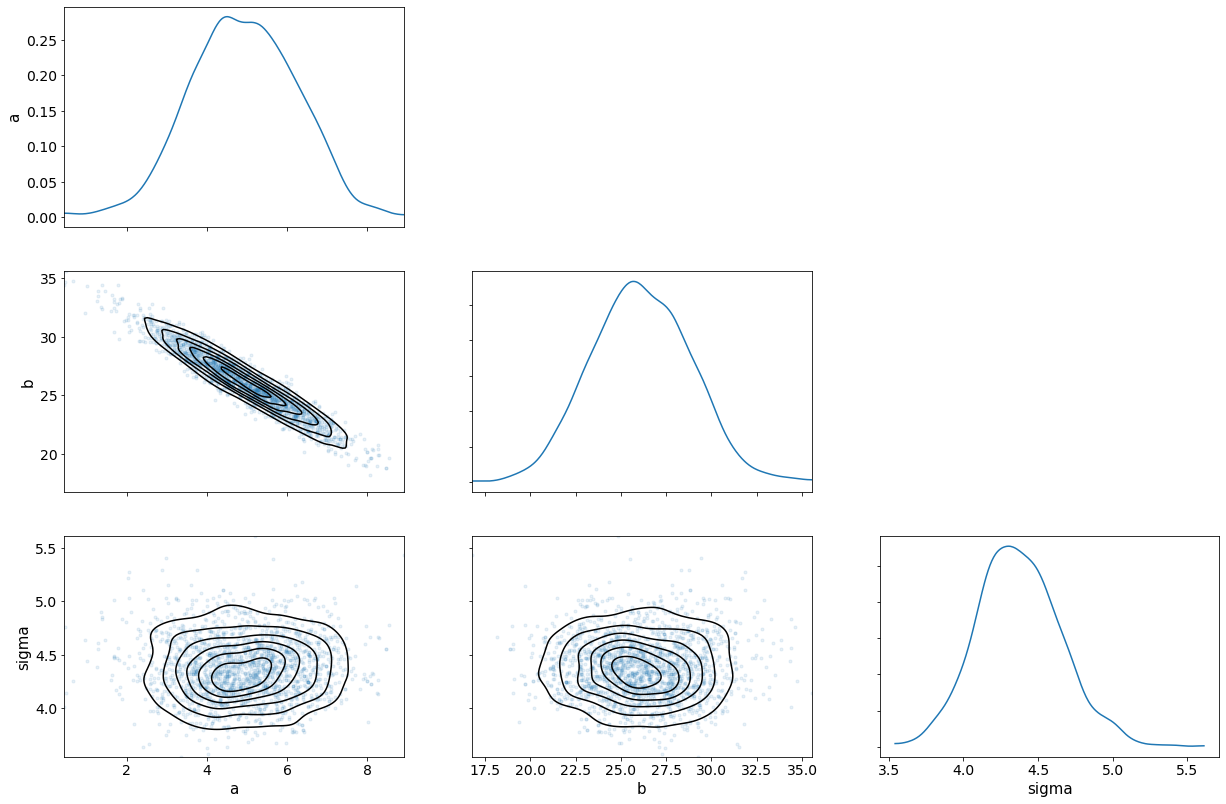

In [51]:
ax = az.plot_pair(
    inference_normal,
    var_names=['a', 'b', 'sigma'],
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

The pair plots shows a high correlation between the parameters $\alpha$ and $\beta$. That is to be expected since the two variables are connected to each other in the equation for the regression line, we would expect the intercept to be smaller when the slope is steeper (a higher value). There isn't any correlation between $\sigma$ and the other two variables. 

#### 2.4. Posterior and Posterior-predictive

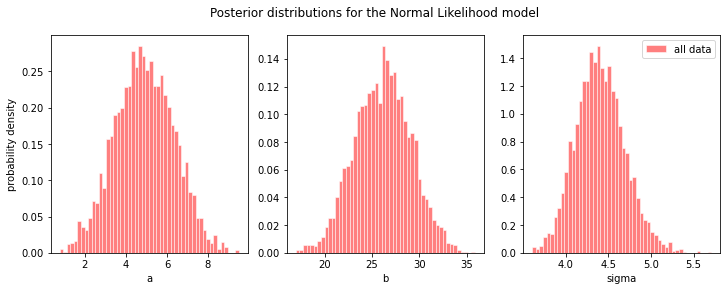

In [17]:
plt.figure(figsize=(12, 4))
plt.suptitle('Posterior distributions for the Normal Likelihood model')
for i, var in enumerate(['a', 'b', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(inference_normal.posterior, var).values.flatten(), density=True, color = 'red', bins=50, edgecolor='white', alpha=0.5, label='all data')
plt.legend()
plt.show() 

C:\Users\saai2\Anaconda3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\saai2\Anaconda3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


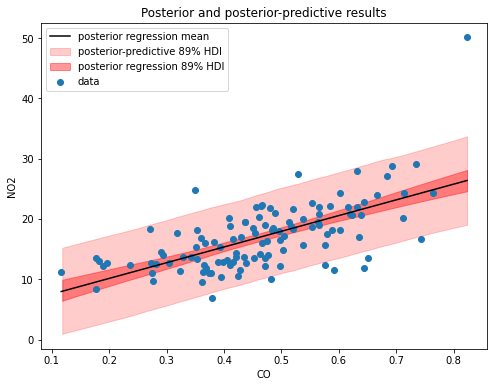

In [23]:
#code adapted from CS146 session 7: linear regression, notebook 'Linear regression' 

posterior_samples = inference_normal.posterior.stack(
    sample=('chain', 'draw')).transpose('sample', ...)

# Compute posterior mu samples
plot_x = np.linspace(data_x.min(), data_x.max(), 200)
posterior_mu_normal = (
    posterior_samples.a.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples.b.values.reshape(1, -1))

# Generate posterior-predictive y samples
posterior_y = sts.norm.rvs(
    loc = posterior_mu_normal,
    scale=posterior_samples.sigma.values.reshape(1, -1),
    size=posterior_mu_normal.shape)

# Plot posterior density intervals
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('CO')
plt.ylabel('NO2')
ax = az.plot_hdi(plot_x, posterior_y.transpose(), hdi_prob=0.89, color='red', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu_normal.transpose(), ax=ax, hdi_prob=0.89, color='red', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu_normal.mean(axis=1), color='black', label='posterior regression mean')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

The above plot shows three main things:
1. The posterior regression mean line (in black), this is a mean of all the lines created using the posterior values of the two parameters. This is the line of best fit evaluated according to our model 
2. Posterior regression 89% HDI (dark pink region): This is the highest density interval with 89% of the regression lines constructed using the posterior parameter values. These are the model's most probable guesses for the regression lines. 
3. Posterior-predictive 89% HDI (light pink region): This is the highest density interval with 89% of posterior predictive values, which generate simulated values of NO2. This is the region the model expects to find 89% of the NO2 values in the population. 


### 3. Model 2 : The student t distribution likelihood

As seen in the previous model, the regression line is skewed towards the outlier. We cannot merely remove the outlier from our dataset manually, since that will bias our model, but we can reduce its impact on the model's estimations. 

The normal distribution has very light tails, which means the probability of observing an outlier value according to the model is very low. But our evidence ends up showing that outlier anyways, so the posterior distribution needs to make $\sigma$ larger to accomodate for that outlier. 

Therefore, with data where we have outliers, the Student T distribution is better to use. Student T distributions has an additional paramter, $\nu$, that adjusts the lightness of the tails. The larger $\nu$ is, the lighter the tails are. As $\nu$ approaches infinity, the T distribution converge to the Normal distribution. 

#### 3.1. Setting up the model

Likelihood:

$$y_i \sim \text{T}(\nu, \mu_i, \sigma^2)$$

$$\mu_i = \alpha + \beta x_i$$

Priors:

$$\alpha \sim \text{Uniform}(0,100)$$

$$\beta \sim \text{Normal}(0,5)$$

$$\sigma \sim \text{Uniform}(0, 100)$$

$$\nu \sim \text{Half_Normal}(\sigma = 30)$$


In our second model, I use the T distributions with the same priors, except with an addition of $\nu$, that follows a half normal distribution so it can be positive

In [24]:
data_x = np.array(air['co_centenario'])
data_y = np.array(air['no2_centenario'])

In [80]:

with pm.Model() as t_model:
    # Prior
    a = pm.Uniform('a', lower=0, upper=100)
    b = pm.Normal('b', mu=0, sigma=5)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    nu = pm.HalfNormal('nu', sigma=30)
    # Data
    x = pm.MutableData('x', data_x)
    y = pm.MutableData('y', data_y)
    # Regression mean
    mu = pm.Deterministic('mu', a + b * x)
    # Likelihood
    pm.StudentT('likelihood', nu=nu,
                mu=mu, sigma=sigma, observed=y)

#### 3.2. Prior predictive

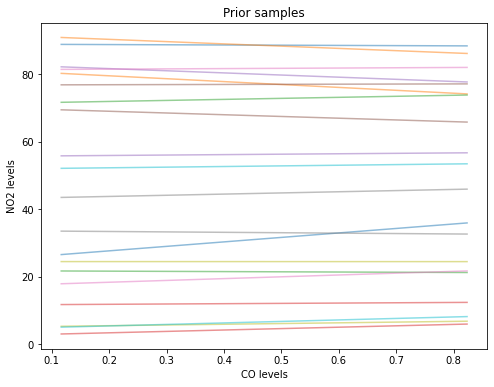

In [84]:
#code adapted from CS146 session 7: linear regression, notebook 'Linear regression' 
with t_model:
    prior_inference_t = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('CO levels')
plt.ylabel('NO2 levels')
plot_x = np.array([data_x.min(), data_x.max()])
plot_y = (
    prior_inference_t.prior.a.values +
    plot_x.reshape(-1, 1) * prior_inference_t.prior.b.values)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

The prior predictive is different than the one observed in the Normal distribution model. Firstly, it does not take into account negative values because our model is different now and includes the parameter $\nu$. And secondly, the slopes are less steep now. 

#### 3.3. Sampler performance analysis

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma, nu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1144 seconds.
The acceptance probability does not match the target. It is 0.8818, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,8.345,1.154,6.133,10.422,0.042,0.030,761.0,994.0,1.0
b,18.193,2.431,13.380,22.403,0.087,0.062,779.0,979.0,1.0
sigma,3.474,0.325,2.901,4.079,0.011,0.008,910.0,1094.0,1.0
nu,7.456,3.934,2.572,14.108,0.139,0.098,931.0,915.0,1.0


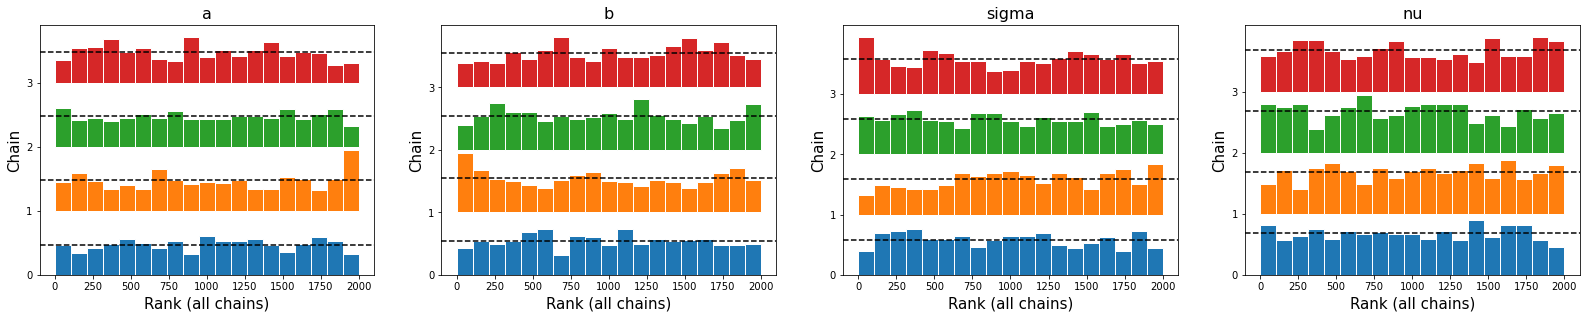

In [52]:
with t_model:
    t_inference = pm.sample(500)

az.plot_rank(t_inference, var_names=['a', 'b', 'sigma', 'nu'])
az.summary(t_inference, var_names=['a', 'b', 'sigma', 'nu'])

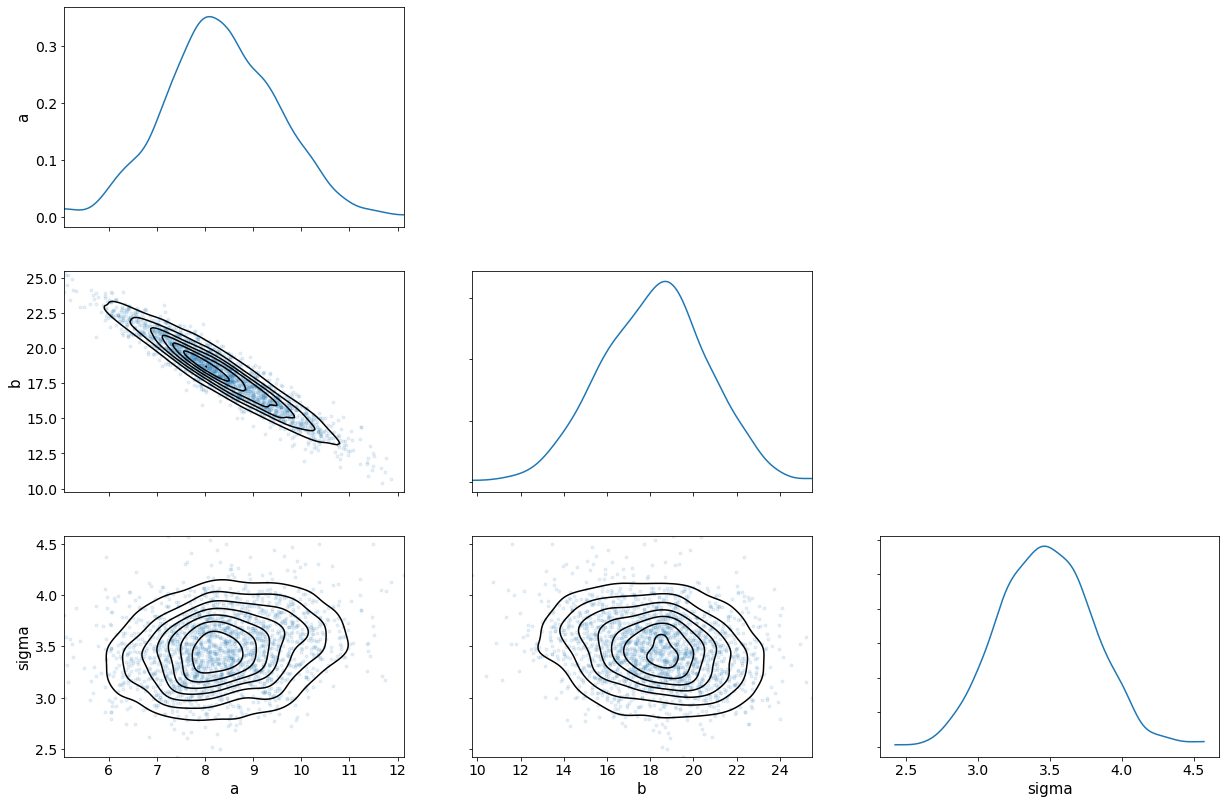

In [53]:
ax = az.plot_pair(
    t_inference,
    var_names=['a', 'b', 'sigma'],
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

Similar to the Normal likelihood model, the sampler is working fine as shown by the $\hat{r}$ and ESS values. The ranks alow show an approximately uniform distribution. 

An interesting thing to note is that the mean values of the parameters have changed. For the normal likelihood, $\alpha$ was 4.9 and $\beta$ was 26, now it is 8.3, and 18, which means the regression line would be less steep (noto skewed towards hte outlier at the top). $\sigma$ values also decreased from 4.4 to 3.4 since the model does not need to have a large $\sigma$ value to encapsulate the outlier.  

#### 3.4. Posterior and Posterior-predictive

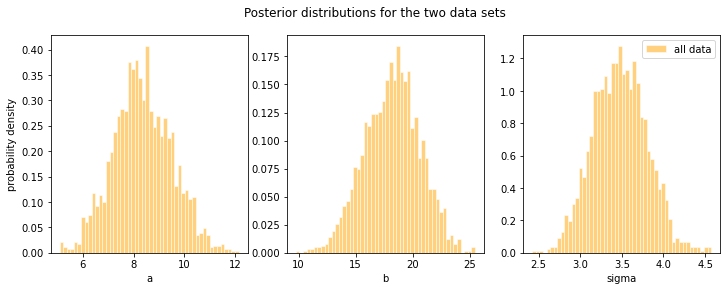

In [92]:
plt.figure(figsize=(12, 4))
plt.suptitle('Posterior distributions for the two data sets')
for i, var in enumerate(['a', 'b', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(t_inference.posterior, var).values.flatten(), density=True, color = 'orange', bins=50, edgecolor='white', alpha=0.5, label='all data')
plt.legend()
plt.show() 

C:\Users\saai2\Anaconda3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\saai2\Anaconda3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


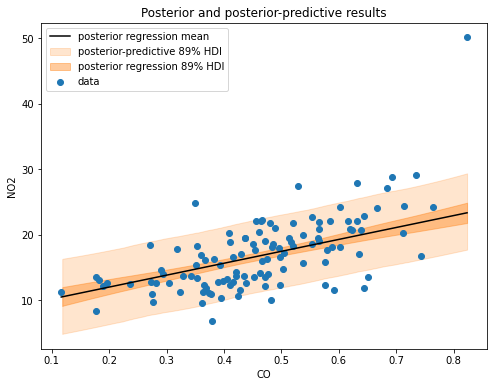

In [77]:
posterior_samples = t_inference.posterior.stack(
    sample=('chain', 'draw')).transpose('sample', ...)

# Compute posterior mu samples
plot_x = np.linspace(data_x.min(), data_x.max(), 200)
posterior_mu_t = (
    posterior_samples.a.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples.b.values.reshape(1, -1))

# Generate posterior-predictive y samples
posterior_y = sts.norm.rvs(
    loc = posterior_mu_t,
    scale=posterior_samples.sigma.values.reshape(1, -1),
    size=posterior_mu_t.shape)

# Plot posterior density intervals
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('CO')
plt.ylabel('NO2')
ax = az.plot_hdi(plot_x, posterior_y.transpose(), hdi_prob=0.89, color='C1', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu_t.transpose(), ax=ax, hdi_prob=0.89, color='C1', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu_t.mean(axis=1), color='black', label='posterior regression mean')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

The posterior and posterior predictive results show the same thing as the previous one, the regression mean line is just less steep now due to different mean parameter values. 

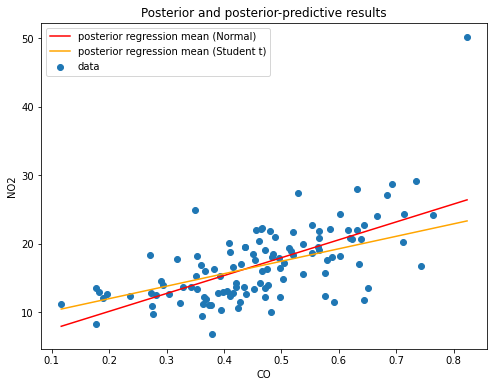

In [58]:
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('CO')
plt.ylabel('NO2')
plt.plot(plot_x, posterior_mu_normal.mean(axis=1), color='red', label='posterior regression mean (Normal)')
plt.plot(plot_x, posterior_mu_t.mean(axis=1), color='orange', label='posterior regression mean (Student t)')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

As an initial comparison I plotted the Normal likelihood model and T distribtution model and there's a clear different difference between the mean lines of the two. The t distribution is clearly less effected by the outlier as compared to the Normal likehlihood model. 

### 4. Model 3: Outlier classifier model

The t distributions helped us half a heavy-tailed distribution, but we assumed that all values were generated from that distribution. However, while values are outliers and need to be sampled from a heavy-tailed distribution, not all of them need to do the same. 

The outlier classifier model encodes this assumption by assigned a binary value to each data point. If the datum is an outlier, its value is 1, and 0 otherwise. This is generated from a Bernoulli distribution with probability p, hence we need a prior over p as well in this model. 

If the value is not an outlier, its variance is equal to $\sigma_{in}$, if it is an outlier, its variance is the sum of $\sigma_{in}$ and $\sigma_{out}$. We add the variances for outliers to make sure it will always be greater. The prior for $\sigma_{in}$ is the same as before, however the prior for $\sigma_{in}$ is a half-normal distribution. 

The outlier classifier model uses a Normal likelihood with parameter $\mu$ and $\sigma$, however the data points can have different variances

#### 4.1. Setting up the model

Likelihood:

$$y_i \sim \text{Normal}(\mu_i, \sigma_i)$$

$$\mu_i = \alpha + \beta x_i$$

$$ \sigma_{i} = \left\{ 
                      \begin{array}{ c l }
                      {\sigma}_{in} & \quad \textrm{if } q_{i} = 0 \\
                      {\sigma}_{in} + {\sigma}_{out} & \quad \textrm{if } q_{i} = 1
                      \end{array}
                      \right. $$

$$q_i \sim \text{Bernoulli}(p)$$

Priors:

$$\alpha \sim \text{Uniform}(0,100)$$

$$\beta \sim \text{Normal}(0,5)$$

$$\sigma_{in} \sim \text{Uniform}(0, 100)$$

$$\sigma_{out} \sim \text{Half-Normal}(0, 30)$$

$$p \sim \text{Uniform}(0, 1/2)$$

In [59]:
data_x = np.array(air['co_centenario'])
data_y = np.array(air['no2_centenario'])

In [60]:
import aesara.tensor as at

with pm.Model() as outlier_model:
    
    # Observed variables
    x = pm.MutableData('x', data_x)
    y = pm.MutableData('y', data_y)
    
    # Linear regression
    a = pm.Uniform('a', lower=0, upper=100)
    b = pm.Normal('b', mu=0, sigma=5)
    mu = pm.Deterministic('mu', a + b * x)
    
    # Noise parameters for inliers and outliers
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    sigma_out = pm.HalfNormal('sigma_out', sigma=30)
    sigmas = at.as_tensor_variable([sigma, sigma + sigma_out])

    # In/out class assignment probability and indicators
    p = pm.Uniform('p', lower=0, upper=0.5)
    is_outlier = pm.Bernoulli('is_outlier', p=p, size=x.shape[0])
    
    pm.Normal('likelihood', mu=mu, sigma=sigmas[is_outlier], observed=y)

#### 4.2. Prior predictive

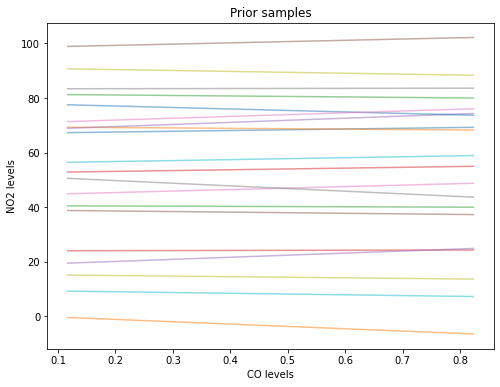

In [85]:
#code adapted from CS146 session 7: linear regression, notebook 'Linear regression' 
with outlier_model:
    prior_inference_outlier = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('CO levels')
plt.ylabel('NO2 levels')
plot_x = np.array([data_x.min(), data_x.max()])
plot_y = (
    prior_inference_outlier.prior.a.values +
    plot_x.reshape(-1, 1) * prior_inference_outlier.prior.b.values)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

The prior predictive plot is very similar to the t distribution model and follows a similar pattern. 

#### 4.3. Sampler performance analysis

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, b, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3543 seconds.
C:\Users\saai2\Anaconda3\lib\site-packages\arviz\stats\diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,8.665,1.147,6.508,10.772,0.039,0.028,865.0,1002.0,1.01
b,17.495,2.350,12.903,21.655,0.080,0.056,865.0,1056.0,1.01
sigma,3.743,0.282,3.237,4.278,0.009,0.007,855.0,649.0,1.00
sigma_out,22.281,14.509,3.450,49.700,0.618,0.437,282.0,456.0,1.01
p,0.035,0.032,0.001,0.087,0.002,0.001,284.0,338.0,1.00


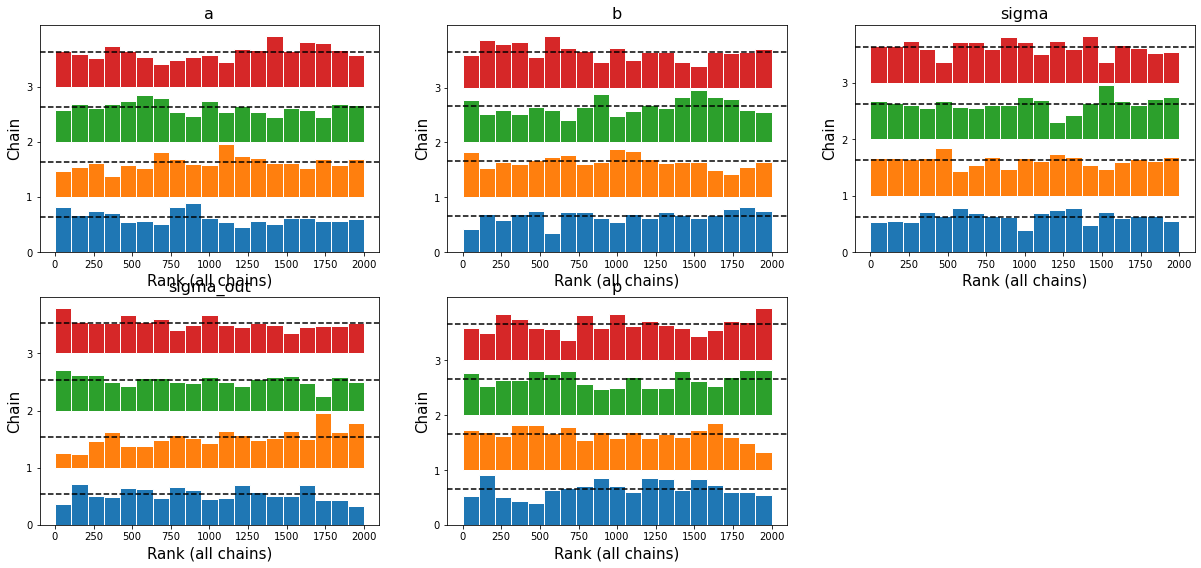

In [61]:
with outlier_model:
    outlier_inference = pm.sample(500)

az.plot_rank(outlier_inference, var_names=['a', 'b', 'sigma', 'sigma_out', 'p'])
az.summary(outlier_inference, var_names=['a', 'b', 'sigma', 'sigma_out', 'p'])

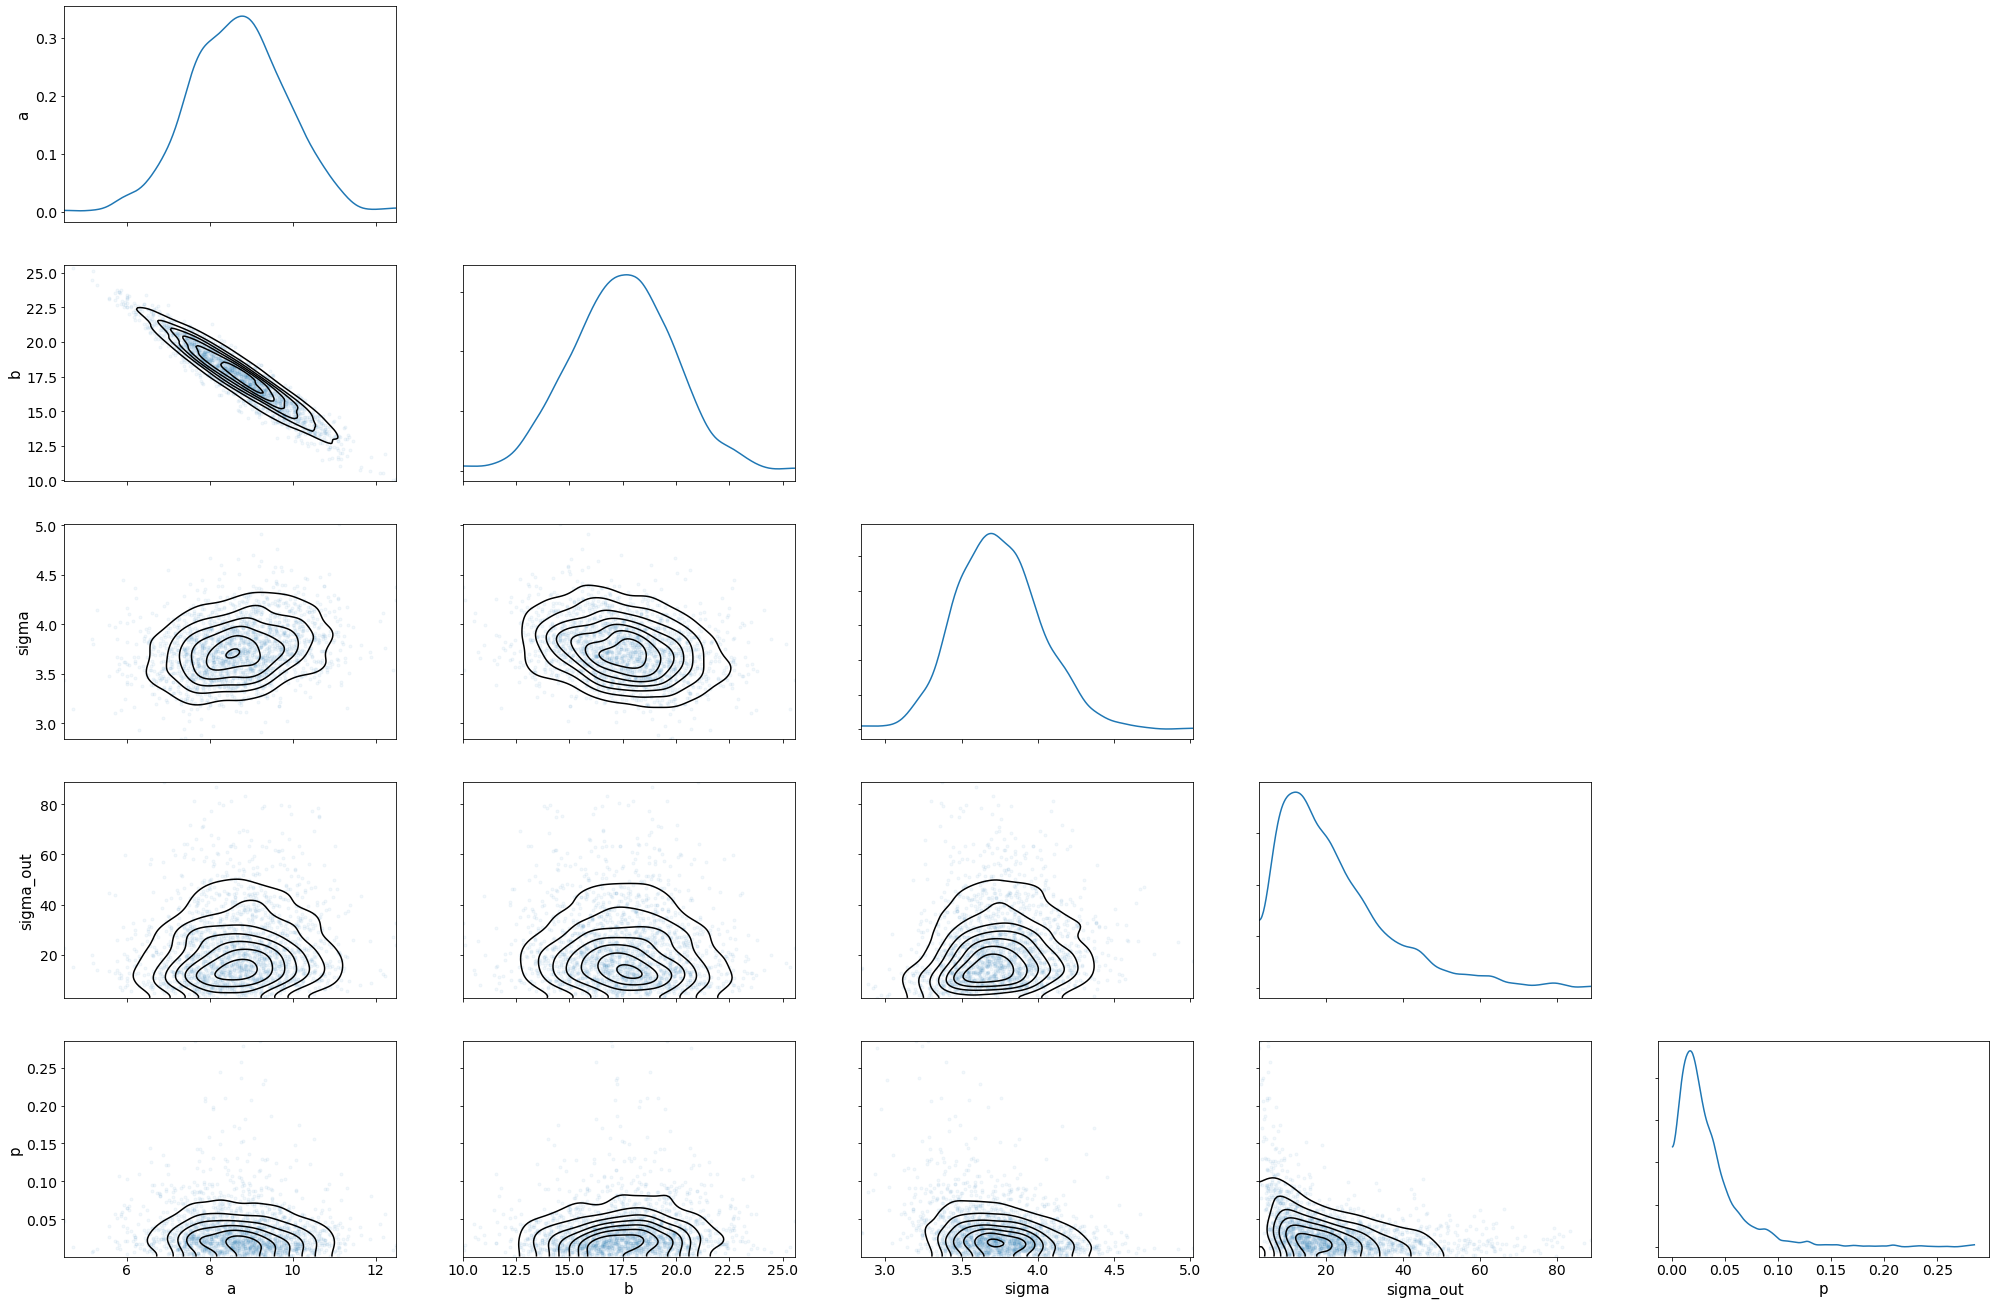

In [66]:
ax = az.plot_pair(
    outlier_inference,
    var_names=['a', 'b', 'sigma', 'sigma_out', 'p'],
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.05},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}},
);

The sampler also seems to be working fine. The $\hat{r}$ values are higher than before, at 1.01, but the model is more complicated as well. Tuning it well can solve these minor discrepencies. 

The parameter values, $\alpha$ and $\beta$ values are very close to the T distribution model, with mean values of 8.6 and 17.5. Hence this model performs very similar to the T distribution model, at least for in sample data. 

#### 4.4. Posterior and posterior-predictive

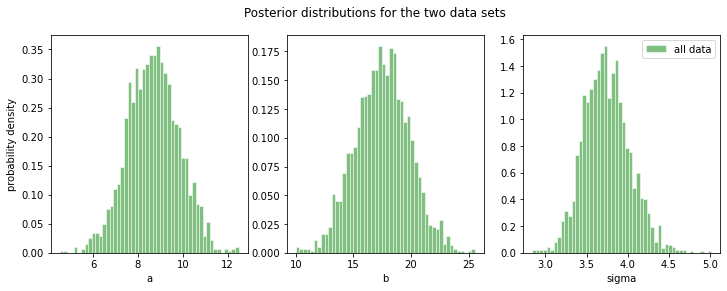

In [94]:
plt.figure(figsize=(12, 4))
plt.suptitle('Posterior distributions for the two data sets')
for i, var in enumerate(['a', 'b', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(outlier_inference.posterior, var).values.flatten(), density=True, color = 'green', bins=50, edgecolor='white', alpha=0.5, label='all data')
plt.legend()
plt.show() 

C:\Users\saai2\Anaconda3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\saai2\Anaconda3\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


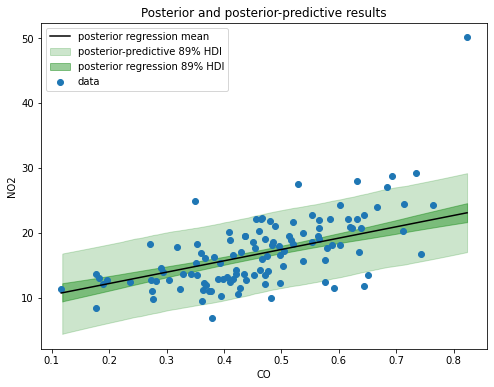

In [75]:
posterior_samples = outlier_inference.posterior.stack(sample=('chain', 'draw')).transpose('sample', ...)

# Compute posterior mu samples
plot_x = np.linspace(data_x.min(), data_x.max(), 200)
posterior_mu_outlier = (
    posterior_samples.a.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples.b.values.reshape(1, -1))

# Generate posterior-predictive y samples
posterior_y = sts.norm.rvs(
    loc = posterior_mu_outlier,
    scale=posterior_samples.sigma.values.reshape(1, -1),
    size=posterior_mu_outlier.shape)

# Plot posterior density intervals
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('CO')
plt.ylabel('NO2')
ax = az.plot_hdi(plot_x, posterior_y.transpose(), hdi_prob=0.89, color='green', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu_outlier.transpose(), ax=ax, hdi_prob=0.89, color='green', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu_outlier.mean(axis=1), color='black', label='posterior regression mean')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

The plot shows similar features as the previous two models explained earlier. 

### 5. Model comparison 

#### 5.1. Comparison of posterior distributions 

In [ ]:
plt.figure(figsize=(12, 4))
plt.suptitle('Posterior distributions for the two data sets')
for i, var in enumerate(['a', 'b', 'sigma']):
    plt.subplot(1, 3, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    plt.hist(getattr(inference_normal.posterior, var).values.flatten(), density=True, color = 'red', bins=50, edgecolor='white', alpha=0.4, label='Normal')
    plt.hist(getattr(t_inference.posterior, var).values.flatten(), density=True, color = 'orange', bins=50, edgecolor='white', alpha=0.4, label='Student T')
    plt.hist(getattr(outlier_inference.posterior, var).values.flatten(), density=True, color = 'green', bins=50, edgecolor='white', alpha=0.4, label='Outlier Classifier')
plt.legend()
plt.show() 

The above plot compares the posterior distributions from the three models. As expected from earlier analysis, the posteriors for the T distribution and the Outlier classifier are very similar, however the Outlier classifier still have parameter means that will likely result in a less steep regression mean line. The Normal distribution model is the most different than the two, primarily because it overestimates the posterior because of the outlier.

#### 5.2. Posterior regression means

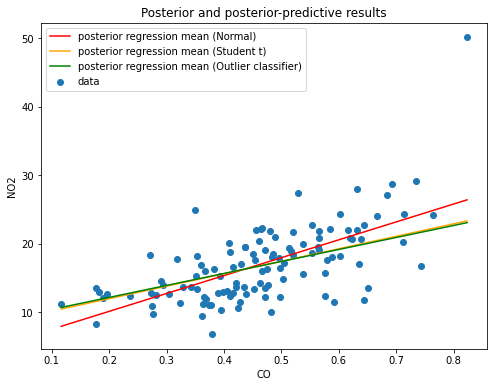

In [71]:
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('CO')
plt.ylabel('NO2')
plt.plot(plot_x, posterior_mu_normal.mean(axis=1), color='red', label='posterior regression mean (Normal)')
plt.plot(plot_x, posterior_mu_t.mean(axis=1), color='orange', label='posterior regression mean (Student t)')
plt.plot(plot_x, posterior_mu_outlier.mean(axis=1), color='green', label='posterior regression mean (Outlier classifier)')
plt.scatter(data_x, data_y, color='C0', label='data')
plt.legend()
plt.show()

When plotting the regression mean lines of the three models, we can see that the Normal distribution models has the steepest line, while the other two highly overlap. The outlier classifier seems to be the most uneffected by the outlier value.  

#### 5.3. Deviance analysis: PSIS 

The previous comparisons were for in sample performance, computing the Pareto-smoothed importance sampling cross-validation (PSIS) value gives insight into the out of sample deviance. Deviance informs us of how good the model fits the data.

PSIS follows leave-one-out-cross-validation (LOO-CV), where we leave out one unique observation and train the model on the rest of the data to predict this one unique value (however in PyMC we only approximate this since it would take too long if we computed 100 posteriors by leaving each one out one by one).


C:\Users\saai2\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\saai2\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\saai2\Anaconda3\lib\site-packages\arviz\stats\stats.py:812: UserWarning: 

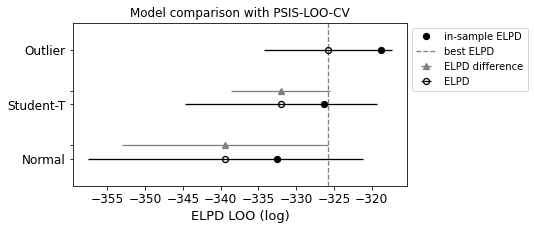

In [64]:
#code adapted from CS146 session 12: Model comparison 3 codebook 'Linear regression on obesity data'

inferences = {'Normal': inference_normal, 'Student-T': t_inference, 'Outlier': outlier_inference}

df = az.compare(inferences, ic='loo')
az.plot_compare(df)
# Add these labels since they are not in the latest release (scheduled for the next one)
plt.title('Model comparison with PSIS-LOO-CV')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['in-sample ELPD', 'best ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

PyMC is using log ELPD values, which is the expected log-posterior predictive density. The above plot shows a comparison of the ELPD LOO values of the three models. The highest ELPD out of sample value (the black ring) is for the outlier classifier model. This is a clear indication that the outlier classifier performs the best out of sample. This is because it catch the general trend of the data the best, without being overly effected by the outlier value. It gives less importance (weight) to the outlier value and hence is not skewed towards it. 

The filled in black dots in the plot represent in sample ELPD, which is the highest for the outlier classifier model as well. The grey lines with a triangle shows the ELPD difference between the given model and the best model. This calculate the point-wise ELPD difference between the two model. The grey lines for the T distribution and the Normal distribution model intersect with Outlier classifier models out of sample ELPD value, which tells us that for some samples the other two models performed as well as the outlier classifier model, but on average the outlier classifier model performed the best. 

However, it should be noted that deviance is an assessment of predictive accuracy, not the true distribution. Even with a low deviance the model could be a worse fit. The PSIS comparison, along with other comparison metrics allows us to conclude the Outlier classifier as the best model. 

<i> * Deviance is caculated by multiplying the ELPD by -2, hence when we interpret deviance smaller deviances are better. </i>